In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install lightgbm

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3352
[LightGBM] [Info] Number of data points in the train set: 9089, number of used features: 21
[LightGBM] [Info] Start training from score 13.787243
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

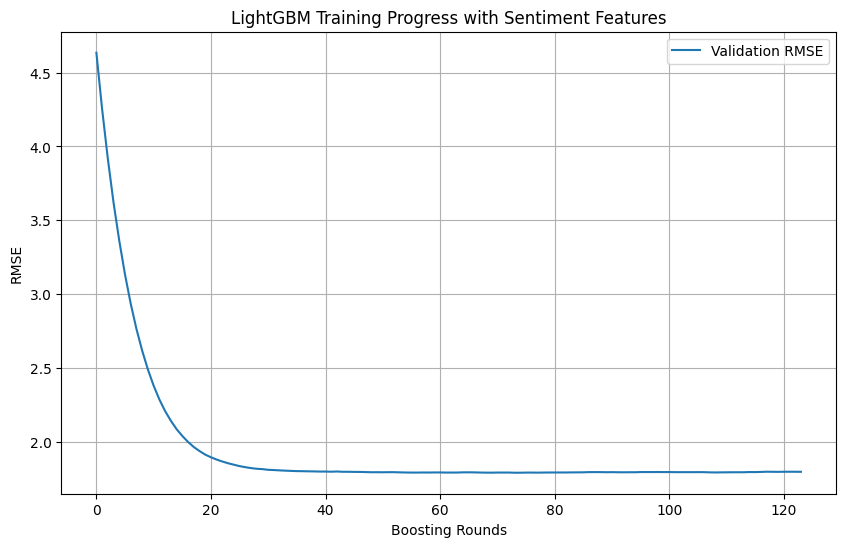

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import matplotlib.pyplot as plt

# === 1. Loading enriched dataset ===
df = pd.read_csv('/content/drive/My Drive/cleaned_movies_with_sentiment.csv')

# === 2. Converting release_date column to datetime format ===
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# === 3. Performing feature engineering ===
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['cast_count'] = df['top_cast'].fillna('').str.split(', ').apply(len)
df['genre_count'] = df['genres'].fillna('').str.split(', ').apply(len)
df['keyword_count'] = df['keywords'].fillna('').str.split(', ').apply(len)

# Extracting top 50 directors and assigning others as 'other'
top_directors = df['director'].value_counts().nlargest(50).index
df['director_clean'] = df['director'].apply(lambda x: x if x in top_directors else 'other')

# Extracting top 50 production companies and assigning others as 'other'
df['main_prod_company'] = df['production_companies'].str.split(', ').str[0]
top_companies = df['main_prod_company'].value_counts().nlargest(50).index
df['main_prod_company'] = df['main_prod_company'].apply(lambda x: x if x in top_companies else 'other')

# Applying log transformation to revenue
df['log_revenue'] = np.log1p(df['revenue'])

# === 4. Converting categorical columns to category dtype ===
categorical_cols = ['language', 'status', 'main_prod_company', 'director_clean']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# === 5. Giving more weight to sentiment/emotion columns ===
sentiment_emotion_cols = [
    'very_negative', 'neutral', 'very_positive',
    'anger', 'disgust', 'joy', 'sadness'
]
for col in sentiment_emotion_cols:
    df[col] = df[col] * 3

# === 6. Defining features and target column ===
drop_cols = ['movie_id', 'imdb_id', 'title', 'revenue', 'release_date',
             'genres', 'top_cast', 'keywords', 'production_companies',
             'director', 'genres_list', 'top_cast_list', 'keywords_list']
features = [col for col in df.columns if col not in drop_cols + ['log_revenue']]
X = df[features]
y = df['log_revenue']

# === 7. Splitting dataset ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# === 8. Initializing LightGBM model ===
model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

# === 9. Fitting the model ===
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    categorical_feature=categorical_cols,
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

# === 10. Evaluation function with custom accuracy ===
def evaluate(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_rev = np.expm1(y_pred)
    y_true_rev = np.expm1(y_true)

    mae = mean_absolute_error(y_true_rev, y_pred_rev)
    rmse = np.sqrt(mean_squared_error(y_true_rev, y_pred_rev))
    within_range = np.abs(y_pred_rev - y_true_rev) <= 10000000
    custom_acc = np.mean(within_range)

    print(f"\n📊 {label} Results:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"Custom ±10M Accuracy: {custom_acc * 100:.2f}%")

# === 11. Plotting LightGBM training progress ===
def plot_training_progress(model):
    evals_result = model.evals_result_
    rmse_vals = evals_result['valid_0']['rmse']

    plt.figure(figsize=(10, 6))
    plt.plot(rmse_vals, label='Validation RMSE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title('LightGBM Training Progress with Sentiment Features')
    plt.legend()
    plt.grid(True)
    plt.show()

# === 12. Evaluate and Plot ===
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")
plot_training_progress(model)
